In [1]:
import wfdb
import matplotlib.pyplot as plt

In [2]:
# Load the record you already loaded
record = wfdb.rdrecord('mitdb/100', pn_dir='mitdb')

# Just plot first 1000 points of channel 0
signal = record.p_signal[:1000, 0]

In [3]:
print(record.p_signal.shape)
print(record.sig_name)

(650000, 2)
['MLII', 'V5']


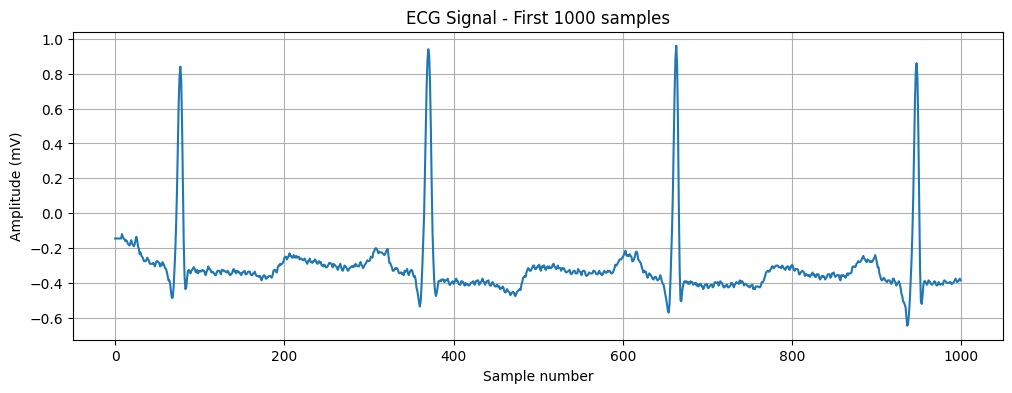

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title("ECG Signal - First 1000 samples")
plt.xlabel("Sample number")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

In [5]:
import numpy as np
print(np.max(signal))        # highest value overall
print(np.argmax(signal))     # WHERE is that highest value?

0.96
663


In [6]:
differences = np.diff(signal)  # calculates signal[i] - signal[i-1] for all i

print("Max difference:", np.max(differences))
print("Min difference:", np.min(differences))
print("Mean difference:", np.mean(differences))
print("Std difference:", np.std(differences))

Max difference: 0.29
Min difference: -0.47000000000000003
Mean difference: -0.0002402402402402402
Std difference: 0.05359818194164604


In [7]:
# signal = record.p_signal[:1000, 0]
# differences = np.diff(signal) # calculates signal[i] - signal[i-1] for all i
#
# results = {}
#
# for threshold in np.arange(0.107, 0.30, 0.01):
#     spike_locations = []
#     for i in range(len(differences)):
#         if differences[i] > threshold:
#             spike_locations.append(i)  # should this be i or i+1? WHY?
#     results[round(threshold, 3)] = len(spike_locations)
#
# print(results)

In [8]:
# signal = record.p_signal[:1000, 0]
# differences = np.diff(signal)
#
# threshold = 0.257  # YOU decide based on mean + std logic above
#
# spike_locations = []
#
# for i in range(len(differences)):
#     if differences[i] > threshold:
#         spike_locations.append(i)
#
# print(spike_locations)
# print("Number of spikes found:", len(spike_locations))

In [9]:
from scipy.signal import find_peaks

signal = record.p_signal[:1000, 0]
peaks, _ = find_peaks(signal, height=0.5, distance=200)
print("Peak locations:", peaks)
print("Peak values:", signal[peaks])

# NOW YOU WRITE THIS PART:
# Calculate differences between consecutive peaks
# What numpy function gives you differences between array elements?

Peak locations: [ 77 370 663 947]
Peak values: [0.84 0.94 0.96 0.86]


In [10]:
rr_intervals=np.diff(peaks)
rr_intervals

array([293, 293, 284])

In [11]:
rr_seconds=rr_intervals/360
rr_seconds

array([0.81388889, 0.81388889, 0.78888889])

In [12]:
HRV=np.std(rr_intervals)
HRV

np.float64(4.242640687119285)

In [13]:
heart_rate=60/rr_seconds
heart_rate

array([73.72013652, 73.72013652, 76.05633803])

In [14]:
features = {
    'mean_hr'    : np.mean(heart_rate),
    'hrv_std'    : np.std(rr_intervals),
    'mean_rr'    : np.mean(rr_intervals),
    'min_rr'     : np.min(rr_intervals),
    'max_rr'     : np.max(rr_intervals),
    'rr_range'   : np.max(rr_intervals) - np.min(rr_intervals)
}
print(features)

{'mean_hr': np.float64(74.49887035523723), 'hrv_std': np.float64(4.242640687119285), 'mean_rr': np.float64(290.0), 'min_rr': np.int64(284), 'max_rr': np.int64(293), 'rr_range': np.int64(9)}


In [15]:
annotation = wfdb.rdann('100', 'atr',pn_dir='mitdb')  # no pn_dir!

In [16]:
print(annotation.sample[:20])
print(annotation.symbol[:20])

[  18   77  370  662  946 1231 1515 1809 2044 2402 2706 2998 3282 3560
 3862 4170 4466 4764 5060 5346]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [17]:
# Count how many of each label exists in patient 100
import collections

all_annotations = wfdb.rdann('100', 'atr', pn_dir='mitdb')
label_counts = collections.Counter(all_annotations.symbol)
print(label_counts)

Counter({'N': 2239, 'A': 33, '+': 1, 'V': 1})


In [18]:
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
import wfdb

def extract_features(record_name):
    # Load signal
    record = wfdb.rdrecord(record_name, pn_dir='mitdb')
    signal = record.p_signal[:, 0]

    # Load annotations
    ann = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')
    ann_symbol = np.array(ann.symbol)

    rows = []
    window_size = 1000

    for start in range(0, len(signal)-window_size, window_size):
        window = signal[start:start+window_size]

        # Find peaks
        peaks, _ = find_peaks(window, height=0.5, distance=200)

        if len(peaks) < 2:
            continue

        rr_intervals = np.diff(peaks)
        rr_seconds=rr_intervals/360
        hr=60/rr_seconds
        # YOU WRITE THESE:
        mean_hr = np.mean(hr)
        hrv_std = np.std(rr_intervals)
        mean_rr = np.mean(rr_intervals)

        # Find label for this window
        # which annotations fall in this window?
        mask = (ann.sample >= start) & (ann.sample < start+window_size)
        window_labels = ann_symbol[mask]

        # Most common label in window
        if len(window_labels) == 0:
            continue
        if 'A' in window_labels or 'V' in window_labels:
            label = 'ABNORMAL'
        else:
            label = 'N'

        rows.append({
            'mean_hr': mean_hr,
            'hrv_std': hrv_std,
            'mean_rr': mean_rr,
            'label': label
        })

    return pd.DataFrame(rows)

In [19]:
df = extract_features('100')
print(df.head())
print(df['label'].value_counts())

     mean_hr    hrv_std     mean_rr     label
0  74.498870   4.242641  290.000000         N
1  74.762863   5.000000  289.000000         N
2  68.531642  28.871362  317.666667  ABNORMAL
3  74.632734  13.000000  290.000000         N
4  72.730571   2.000000  297.000000         N
label
N           615
ABNORMAL     34
Name: count, dtype: int64


In [20]:
print("RR intervals:", rr_intervals)
print("RR seconds:", rr_seconds)
print("HR values:", 60/rr_seconds)

RR intervals: [293 293 284]
RR seconds: [0.81388889 0.81388889 0.78888889]
HR values: [73.72013652 73.72013652 76.05633803]


In [21]:
records = wfdb.get_record_list('mitdb')
print(records)
print(len(records))

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
48


In [ ]:
all_dfs = []
for record in records:
    try:
        df = extract_features(record)
        df['patient'] = record  # track which patient
        all_dfs.append(df)
    except:
        print(f"Skipped: {record}")x

final_df = pd.concat(all_dfs, ignore_index=True)
print(final_df.shape)
print(final_df['label'].value_counts())

Skipped: 208
